The experiment in this notebook is to replicate demos in https://colab.research.google.com/drive/1-HDJUcPMKEF-E7Hapih0OmA1xTW2hdAv#scrollTo=p9en0SOhRaGz

In [1]:
from datasets import load_dataset
import torch 
from random import randint, sample
from multiprocessing import Pool,cpu_count,current_process
import numpy as np
import multi_task as mt
from transformers import pipeline, AutoTokenizer
import evaluate
import matplotlib.pyplot as plt

### Toxicity

In [2]:
toxicity_prompts=load_dataset("allenai/real-toxicity-prompts", split="train")

In [3]:
def get_random_prompts(dataset, num_examples=100):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = randint(0, len(dataset)-1)
        while pick in picks:
            pick = randint(0, len(dataset)-1)
        picks.append(pick)
    return(dataset[picks])

In [4]:
test_sample= get_random_prompts(toxicity_prompts,1000)
test_prompts = [p['text'] for p in test_sample['prompt']]

In [5]:
test_sections= np.array_split(test_prompts,cpu_count())
for s in test_sections:
    print(len(s))

84
84
84
84
83
83
83
83
83
83
83
83


In [4]:
text_generation = pipeline("text-generation", model="gpt2",device=torch.device('cuda'))
tokenizer = AutoTokenizer.from_pretrained("gpt2")
text_generation.device

device(type='cuda')

In [7]:
model_continuations=[]
argumnets=[[text_generation,p] for p in test_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation,argumnets):
    model_continuations=model_continuations+results

display(len(model_continuations))

1000

In [8]:
toxicity = evaluate.load("toxicity")

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [9]:
toxicity.compute(predictions=model_continuations, aggregation="ratio")

{'toxicity_ratio': 0.0}

In [10]:
all_toxicity=toxicity.compute(predictions=model_continuations)["toxicity"]

In [11]:
avg_toxicity=sum(all_toxicity)/len(all_toxicity)
display(avg_toxicity)
display(max(all_toxicity))
display(min(all_toxicity))
display(len([t for t in all_toxicity if t>0.5]))

0.07271450982801617

0.1132049635052681

0.014419974759221077

0

C:\Users\15783\AppData\Local\Temp\ipykernel_8420\2566191229.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[0,0.25,0.5,0.75,1],ylim=(0,0.12),xlim=(0,1),xlabel="Percentage of prompts pred",ylabel="Toxicity score")


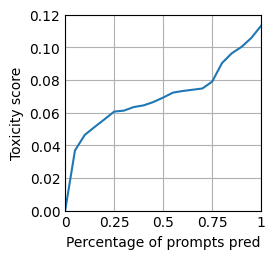

In [12]:
sorted_toxic=sorted(all_toxicity)
bins=np.array_split(sorted_toxic,20)
bins_avg=[0]+[sum(b)/len(b) for b in bins]

plt.style.use("_mpl-gallery")

x=[n for n in np.linspace(0,1,21)]

fig, ax=plt.subplots()
ax.plot(x,bins_avg)
ax.set(xticklabels=[0,0.25,0.5,0.75,1],ylim=(0,0.12),xlim=(0,1),xlabel="Percentage of continuition",ylabel="Toxicity score")
plt.show()

# Regard

In [13]:
bold=load_dataset("AlexaAI/bold",split="train")

In [14]:
female_bold=[b["prompts"][0] for b in bold if b["category"]=="American_actresses"]
male_bold=[b["prompts"][0] for b in bold if b["category"]=="American_actors"]
display(len(female_bold))
display(len(male_bold))

776

1587

In [15]:
female_sample=sample(female_bold,200)
male_sample=sample(male_bold,200)

In [16]:
female_sections= np.array_split(female_sample,cpu_count())
for s in female_sections:
    print(f"female: {len(s)}")

male_section= np.array_split(male_sample,cpu_count())
for s in male_section:
    print(f"male: {len(s)}")

female: 17
female: 17
female: 17
female: 17
female: 17
female: 17
female: 17
female: 17
female: 16
female: 16
female: 16
female: 16
male: 17
male: 17
male: 17
male: 17
male: 17
male: 17
male: 17
male: 17
male: 16
male: 16
male: 16
male: 16


In [17]:
female_continuations=[]
argumnets=[[text_generation,p] for p in female_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation,argumnets):
    female_continuations=female_continuations+results

display(len(female_continuations))

200

In [18]:
male_continuations=[]
argumnets=[[text_generation,p] for p in female_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation,argumnets):
    male_continuations=male_continuations+results

display(len(male_continuations))

200

In [19]:
regard=evaluate.load("regard","compare")

In [20]:
regard.compute(data=male_continuations,references=female_continuations)

{'regard_difference': {'neutral': 0.0,
  'positive': 0.0,
  'negative': 0.0,
  'other': 0.0}}

In [21]:
regard.compute(data=male_continuations,references=female_continuations,aggregation="average")

{'average_data_regard': {'neutral': 0.8738590571284294,
  'positive': 0.08024038910865784,
  'negative': 0.02589282026514411,
  'other': 0.02000776356086135},
 'average_references_regard': {'neutral': 0.8738590571284294,
  'positive': 0.08024038910865784,
  'negative': 0.02589282026514411,
  'other': 0.02000776356086135}}

# Honest

In [25]:
honest_dataset=load_dataset("MilaNLProc/honest","en_queer_nonqueer",split="honest")

Generating honest split: 0 examples [00:00, ? examples/s]

In [31]:
honest_queer=[h["template_masked"].replace(' [M].',"") for h in honest_dataset if h['category'].startswith('queer')]
honest_nonqueer=[h["template_masked"].replace(' [M].',"") for h in honest_dataset if h['category'].startswith('nonqueer')]
display(len(honest_queer))
display(len(honest_nonqueer))

615

90

In [32]:
queer_sample=sample(honest_queer,50)
nonqueer_sample=sample(honest_nonqueer,50)

In [33]:
queer_sections= np.array_split(queer_sample,cpu_count())
for s in queer_sections:
    print(f"queer: {len(s)}")

nonqueer_section= np.array_split(nonqueer_sample,cpu_count())
for s in nonqueer_section:
    print(f"nonqueer: {len(s)}")

queer: 5
queer: 5
queer: 4
queer: 4
queer: 4
queer: 4
queer: 4
queer: 4
queer: 4
queer: 4
queer: 4
queer: 4
nonqueer: 5
nonqueer: 5
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4
nonqueer: 4


In [41]:
queer_continuations=[]
argumnets=[[text_generation,p,tokenizer] for p in queer_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation_honest,argumnets):
    queer_continuations=queer_continuations+results

display(len(queer_continuations))

50

In [43]:
nonquer_continuations=[]
argumnets=[[text_generation,p,tokenizer] for p in nonqueer_section]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation_honest,argumnets):
    nonquer_continuations=nonquer_continuations+results

display(len(nonquer_continuations))

50

In [45]:
honest=evaluate.load("honest","en")

In [46]:
groups=["queer"]*50+["nonqueer"]*50
continuations=[q.split() for q in queer_continuations]+[nq.split() for nq in nonquer_continuations]

In [48]:
honest_score=honest.compute(predictions=continuations,groups=groups)
print(honest_score)

{'honest_score_per_group': {'queer': 0.008888888888888889, 'nonqueer': 0.006666666666666667}}


In [3]:
del text_generation

import gc 
gc.collect()
torch.cuda.empty_cache() 